# Generate Dataset for Multi Class Segmentation

In [1]:
import cv2
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Cityscapes


https://www.cityscapes-dataset.com/examples/#fine-annotations

Dataset location:

```
/hdd/team_2/freiburg_forest
```

In [2]:
from collections import namedtuple
#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------
# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

## ON FINE DATA

In [4]:
path = '/data/CITYSCAPES'
images_train_path = os.path.join(path,'leftImg8bit','train')
images_train = sorted(glob.glob(os.path.join(images_train_path, "**/*.png"), recursive=True))
print("IMAGES {} ### Total:  {}".format(images_train_path, len(images_train)))
mask_train_path = os.path.join(path,'gtFine','train')
mask_train = sorted(glob.glob(os.path.join(mask_train_path, "**/*color.png"), recursive=True))
print("MASK {} ### Total:  {}".format(mask_train_path, len(mask_train)))

IMAGES /data/CITYSCAPES/leftImg8bit/train ### Total:  2975
MASK /data/CITYSCAPES/gtFine/train ### Total:  2975


In [5]:
# Valid Data
path = '/data/CITYSCAPES'
images_val_path = os.path.join(path, 'leftImg8bit','val')
images_val = sorted(glob.glob(os.path.join(images_val_path, "**/*.png"), recursive=True))
print("IMAGES {} ### Total:  {}".format(images_val_path, len(images_val)))

mask_val_path = os.path.join(path,'gtFine','val')
mask_val = sorted(glob.glob(os.path.join(mask_val_path, "**/*color.png"), recursive=True))
print("MASK {} ### Total:  {}".format(mask_val_path, len(mask_val)))

IMAGES /data/CITYSCAPES/leftImg8bit/val ### Total:  500
MASK /data/CITYSCAPES/gtFine/val ### Total:  500


In [6]:
df_train_city = pd.DataFrame(columns=['rgb_path','depth_path','mask_path','dataset'])
df_train_city['rgb_path'] = images_train
df_train_city['mask_path'] = mask_train
df_train_city['dataset']  = 'CITYSCAPES'
df_train_city['class'] = 1 # On-road Data


df_valid_city = pd.DataFrame(columns=['rgb_path','depth_path','mask_path','dataset'])
df_valid_city['rgb_path'] = images_val
df_valid_city['mask_path'] = mask_val
df_valid_city['dataset']  = 'CITYSCAPES'
df_valid_city['class'] = 1 # On-road Data

df_train_city, df_test_city = train_test_split(df_train_city, test_size=0.20, random_state=42)



# print("train data: {}".format(len(df_train_city)))
# print("test data: {}".format(len(df_test_city)))
# print("val data: {}".format(len(df_valid_city)))

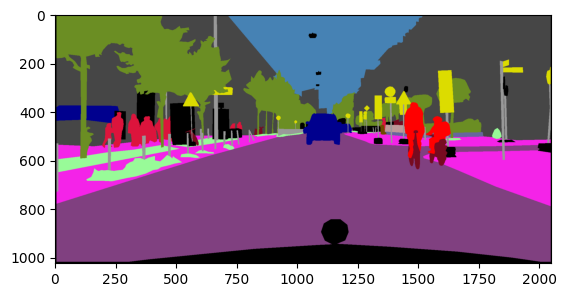

In [7]:
data = cv2.imread(df_train_city["mask_path"].iloc[10])
data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
plt.imshow(data)

In [8]:
train_shuffle = shuffle(df_train_city, random_state=42)

test_shuffle = shuffle(df_test_city, random_state=42)

valid_shuffle = shuffle(df_valid_city, random_state=42)

print("Train data: {}".format(len(train_shuffle)))
print("Test data: {}".format(len(test_shuffle)))
print("Validation data: {}".format(len(valid_shuffle)))

# train_shuffle.to_csv("../data_splits/train_path.csv")
# valid_shuffle.to_csv("../data_splits/valid_path.csv")
# test_shuffle.to_csv("../data_splits/test_path.csv")

Train data: 2380
Test data: 595
Validation data: 500


In [9]:
def show_random_images_cityscapes(images, masks, labels, id):
    # Randomly choose an image from each list
    random_choice = int(random.choice(np.arange(0,len(images),1)))
    
    # Load the images using PIL
    img = cv2.imread(images[random_choice])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(masks[random_choice])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    print("image {}".format(images[random_choice]))
    print("mask {}".format(masks[random_choice]))

    # mask = cv2.resize(mask, [256, 256])
    road_label = np.array(labels[id].color)
    mask = np.all(mask == road_label, axis=-1).astype(np.uint8)

    print("image {}".format(img.shape))
    print("mask {}".format(mask.shape))
    
    # Create a figure with subplots to display the images
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Display the images
    axes[0].imshow(img)
    axes[0].set_title('RGB Image')
    axes[0].axis('off')
    
    
    axes[1].imshow(mask)
    axes[1].set_title('Mask Image')
    axes[1].axis('off')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

image /data/CITYSCAPES/leftImg8bit/train/stuttgart/stuttgart_000053_000019_leftImg8bit.png
mask /data/CITYSCAPES/gtFine/train/stuttgart/stuttgart_000053_000019_gtFine_color.png
image (1024, 2048, 3)
mask (1024, 2048)


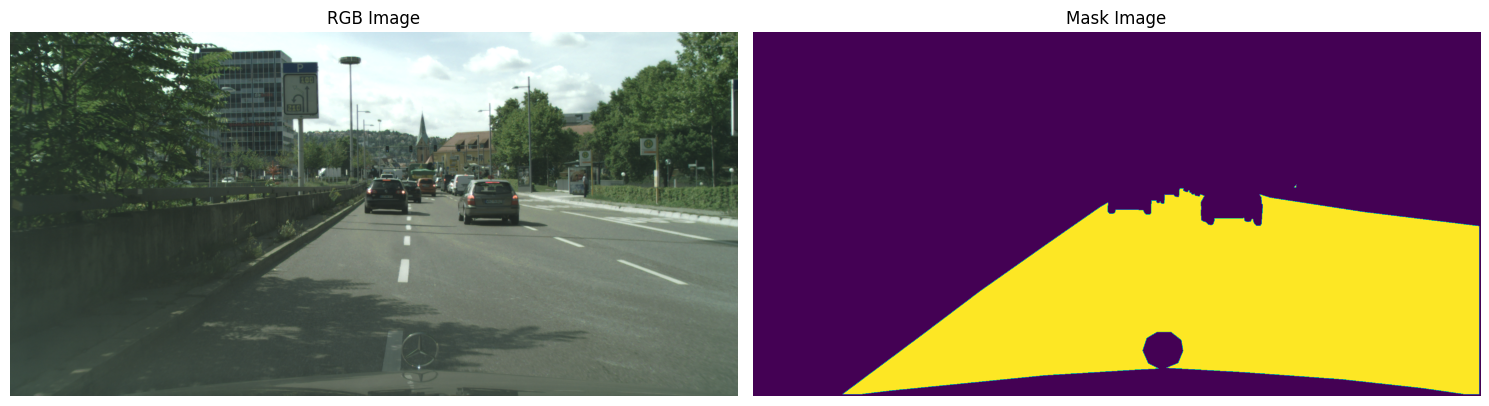

In [10]:
show_random_images_cityscapes(df_train_city["rgb_path"].values, df_train_city["mask_path"].values, labels, 7)